In [63]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

%matplotlib inline
plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'font.size': 20,
        'figure.figsize': (10, 7),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })

# https://www.kaggle.com/competitions/practical-ml-chocolate/data
# https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings/

# Get data

In [64]:
df_train = pd.read_csv('chocolate_train.csv')
df_test = pd.read_csv('chocolate_test_new.csv')
df_full = pd.concat([df_train.drop('Rating', axis=1), df_test])
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [65]:
print(f'Train data has {df_train.shape[1]} columns and {df_train.shape[0]} rows')
print(f'Train data has {df_test.shape[1]} columns and {df_test.shape[0]} rows')

Train data has 9 columns and 1255 rows
Train data has 8 columns and 540 rows


In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [67]:
# Make percentage float
df_train['Cocoa Percent'] = df_train['Cocoa Percent'].apply(lambda x: float(x.strip('%')))
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].apply(lambda x: float(x.strip('%')))
df_full['Cocoa Percent'] = df_full['Cocoa Percent'].apply(lambda x: float(x.strip('%')))

In [68]:
df_train.describe()

,REF,Review,Cocoa Percent,Rating
count,1255.000000,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,71.790438,3.176494
std,551.284249,2.922499,6.397448,0.478948
min,5.000000,2006.000000,46.000000,1.000000
25%,593.000000,2010.000000,70.000000,2.750000
50%,1077.000000,2013.000000,70.000000,3.250000
75%,1514.000000,2015.000000,75.000000,3.500000
max,1952.000000,2017.000000,100.000000,5.000000


## Fill NaNs and empty cells

In [69]:
df_train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               1
Broad Bean Origin       1
dtype: int64

We have more empty cell then NaNs, so replace them with NaNs

In [70]:
df_train = df_train.applymap(lambda x: np.nan if str(x).strip()=="\xa0" else x)
df_train = df_train.applymap(lambda x: np.nan if str(x).strip()=="" else x)

df_test = df_test.applymap(lambda x: np.nan if str(x).strip()=="\xa0" else x)
df_test = df_test.applymap(lambda x: np.nan if str(x).strip()=="" else x)

df_full = df_full.applymap(lambda x: np.nan if str(x).strip()=="\xa0" else x)
df_full = df_full.applymap(lambda x: np.nan if str(x).strip()=="" else x)

In [71]:
df_train.isna().sum()

Company                   0
Specific Bean Origin      0
REF                       0
Review                    0
Cocoa Percent             0
Company Location          0
Rating                    0
Bean Type               629
Broad Bean Origin        56
dtype: int64

### Bean Type

In [72]:
df_full['Bean Type'].value_counts()

Trinitario                  419
Criollo                     153
Forastero                    87
Forastero (Nacional)         52
Blend                        41
Criollo, Trinitario          39
Forastero (Arriba)           37
Criollo (Porcelana)          10
Trinitario, Criollo           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Beniano                       3
EET                           3
Nacional (Arriba)             3
Matina                        3
Criollo, Forastero            2
Forastero (Catongo)           2
Trinitario (85% Criollo)      2
Nacional                      2
Criollo (Ocumare 61)          2
Amazon, ICS                   2
Amazon mix                    2
Criollo (Amarru)              2
Trinitario, Forastero         2
Trinitario (Scavina)          1
Criollo (Ocumare 67)          1
Trinitario, Nacional          1
Criollo (Ocumare 77)          1
Criollo, +                    1
Trinitario, TCGA              1
Amazon                        1
Foraster

In [73]:
mode_bean_type = df_full['Bean Type'].mode()[0]
print('Most porbable value of Bean Type ->', mode_bean_type)

Most porbable value of Bean Type -> Trinitario


Now we have two options:
* Replace all missing values in "Bean Type" with mode ("Trinitario")
* Replace it with new value, i.e. "Mixed"

In [74]:
# My initial solution

df_train['Bean Type'].fillna('Mixed', inplace=True)
df_test['Bean Type'].fillna('Mixed', inplace=True)
df_full['Bean Type'].fillna('Mixed', inplace=True)

### Common Bean Type

In [75]:
common_bean_types = ['Trinitario', 'Criollo', 'Forastero']

def common_bean(s):
    answer = 'Other'
    for i in common_bean_types:
        if i in s:
            answer = i
    return answer
            
df_train['Common Bean Type'] = df_train['Bean Type'].apply(lambda x: common_bean(x))
df_test['Common Bean Type'] = df_test['Bean Type'].apply(lambda x: common_bean(x))
df_full['Common Bean Type'] = df_full['Bean Type'].apply(lambda x: common_bean(x))

In [76]:
df_train.groupby('Common Bean Type').agg({'Rating': np.mean})

,Rating
Common Bean Type,
Criollo,3.229299
Forastero,3.093750
Other,3.146772
Trinitario,3.257812


### Broad Bean Origin

In [77]:
df_full['Broad Bean Origin'].value_counts()[:10]

Venezuela             214
Ecuador               193
Peru                  165
Madagascar            145
Dominican Republic    141
Nicaragua              60
Brazil                 58
Bolivia                57
Belize                 49
Papua New Guinea       42
Name: Broad Bean Origin, dtype: int64

In [78]:
mode_broad_bean_origin = df_full['Broad Bean Origin'].mode()[0]
print('Most porbable value of Broad Bean Origin ->', mode_broad_bean_origin)

Most porbable value of Broad Bean Origin -> Venezuela


One possible solution is to eplace it with 'Mixed' value as we don't have the obovious origin

In [79]:
# My initial solution

df_train['Broad Bean Origin'].fillna('Unknown', inplace=True)
df_test['Broad Bean Origin'].fillna('Unknown', inplace=True)
df_full['Broad Bean Origin'].fillna('Unknown', inplace=True)

In [80]:
df_train.groupby('Broad Bean Origin')\
    .agg(MeanRating=('Rating', 'mean'), Count=('Broad Bean Origin', 'count'))\
    .sort_values(by=['Count', 'MeanRating'], ascending=[False, False])[:20]

,MeanRating,Count
Broad Bean Origin,,
Venezuela,3.236111,144
Ecuador,3.110915,142
Peru,3.151639,122
Dominican Republic,3.194712,104
Madagascar,3.252427,103
Unknown,2.941964,56
Brazil,3.255814,43
Nicaragua,3.178571,42
Bolivia,3.160714,42


### Company

In [81]:
df_train.groupby('Company')\
    .agg(MeanRating=('Rating', 'mean'), Count=('Company', 'count'))\
    .sort_values(by=['Count', 'MeanRating'], ascending=[False, False])[:20]

,MeanRating,Count
Company,,
Soma,3.614286,35
Bonnat,3.387500,20
A. Morin,3.394737,19
Fresco,3.426471,17
Arete,3.468750,16
Pralus,3.453125,16
Valrhona,3.296875,16
Hotel Chocolat (Coppeneur),3.000000,15
Rogue,3.446429,14


# Feature engineering

Some ideas I already tried:
* Broad company location (Africa, Caribbean, etc)
* Broader cocoa bean origin (Africa, Caribbean, etc)
* Best Companies (from internet sources)
* Top cocoa bean production countries (amount and quality)

More to try:
* Company location matches broad bean origin
* Analyze text of some features: Specific Bean Origin and Company

### Broad Locations (parts of the world)

In [82]:
broad_locations = {'Europe': ['U.K.', 'Switzerland', 'France', 'Belgium', 'Spain', 'Italy',
                              'Austria', 'Sweden', 'Ireland', 'Poland', 'Hungary', 'Germany',
                              'Denmark', 'Lithuania', 'Scotland', 'Finland', 'Iceland',
                              'Amsterdam', 'Wales', 'Netherlands', 'Portugal', 'Czech Republic'],
                   'North America': ['U.S.A.', 'Canada'],
                   'Africa': ['Madagascar', 'South Africa', 'Ghana', 'Sao Tome', 'Tanzania',
                              'Indonesia', 'Congo', 'Liberia', 'Principe', 'Sao Tome & Principe',
                              'Gabon', 'Ivory Coast', 'Uganda', 'Nigeria', 'West Africa'],
                   'Caribbean': ['Colombia', 'Venezuela', 'Honduras', 'Guatemala',
                                 'Domincan Republic', 'Grenada', 'Puerto Rico', 'Costa Rica',
                                 'St. Lucia', 'Nicaragua', 'Martinique', 'Niacragua', 'Cost Rica, Ven',
                                 'Trinidad', 'Panama', 'Jamaica', 'Haiti', 'Cuba', 'Venezuela, Ghana',
                                 'Ven.,Ecu.,Peru,Nic.', 'Tobago', 'Carribean(DR/Jam/Tri)',
                                 'Venezuela, Java', 'Ven, Bolivia, D.R.', 'Venezuela, Carribean',
                                 'Dominican Republic', 'Carribean'],
                   'Asia & Oceania': ['Japan', 'Vietnam', 'Philippines', 'Fiji', 'Australia',
                                      'South Korea', 'Israel', 'Singapore', 'India', 'Russia',
                                      'New Zealand', 'Papua New Guinea', 'Hawaii', 'Solomon Islands',
                                      'Sri Lanka', 'Malaysia', 'Samoa', 'Philippines', 'Togo',
                                      'Vanuatu'],
                   'South America': ['Ecuador', 'Brazil', 'Peru', 'Eucador', 'Argentina',
                                     'Chile', 'Mexico', 'Bolivia', 'Suriname', 'Peru, Dom. Rep',
                                     'Central and S. America', 'Colombia, Ecuador', 'Dom. Rep., Madagascar',
                                     'South America', 'Belize', 'El Salvador'],
                   'Mixed': ['Trinidad, Ecuador', 'South America, Africa', 'PNG, Vanuatu, Mad',
                             'Mad., Java, PNG', 'Peru, Mad., Dom. Rep.', 'Indonesia, Ghana', 'Madagascar & Ecuador',
                             'Venez,Africa,Brasil,Peru,Mex', 'DR, Ecuador, Peru', 'Dominican Rep., Bali',
                             'Peru, Madagascar', 'Venezuela, Dom. Rep.', 'Peru, Ecuador, Venezuela',
                             'Ven., Trinidad, Mad.', 'Ven., Indonesia, Ecuad.', 'Ghana, Domin. Rep',
                             'Peru, Belize', 'Guat., D.R., Peru, Mad., PNG']
                   }

In [83]:
def location_in_list(location, locations_dict=broad_locations):
    for k, v in broad_locations.items():
        if location in v:
            return k
    return 'Other'

In [84]:
df_train['Broad Company Location'] = df_train['Company Location'].apply(lambda x: location_in_list(x))
df_test['Broad Company Location'] = df_test['Company Location'].apply(lambda x: location_in_list(x))
df_full['Broad Company Location'] = df_full['Company Location'].apply(lambda x: location_in_list(x))

In [85]:
df_train.groupby('Broad Company Location').agg(MeanRating=('Rating', 'mean'),
                                               StdRating=('Rating', 'std'))

,MeanRating,StdRating
Broad Company Location,,
Africa,3.013158,0.669129
Asia & Oceania,3.253165,0.382916
Caribbean,3.137097,0.423871
Europe,3.207816,0.520794
North America,3.171721,0.447259
South America,3.051829,0.539687


In [86]:
df_train['Bean Origin World'] = df_train['Broad Bean Origin'].apply(lambda x: location_in_list(x))
df_test['Bean Origin World'] = df_test['Broad Bean Origin'].apply(lambda x: location_in_list(x))
df_full['Bean Origin World'] = df_full['Broad Bean Origin'].apply(lambda x: location_in_list(x))

In [87]:
df_train.groupby('Bean Origin World').agg(MeanRating=('Rating', 'mean'),
                                          StdRating=('Rating', 'std'))

,MeanRating,StdRating
Bean Origin World,,
Africa,3.201777,0.475372
Asia & Oceania,3.255208,0.362700
Caribbean,3.193803,0.451452
Mixed,3.342105,0.426635
Other,2.941964,0.724555
South America,3.150243,0.486801


### Some features from Specific Bean Origin

In [88]:
df_train['SBO Complexity'] = df_train['Specific Bean Origin'].apply(lambda x: x.count(' '))
df_test['SBO Complexity'] = df_test['Specific Bean Origin'].apply(lambda x: x.count(' '))
df_full['SBO Complexity'] = df_full['Specific Bean Origin'].apply(lambda x: x.count(' '))

In [89]:
df_train.groupby('SBO Complexity').agg({'Rating': 'mean', 'SBO Complexity': 'count'})

,Rating,SBO Complexity
SBO Complexity,,
0,3.116896,509
1,3.182515,326
2,3.211648,176
3,3.193277,119
4,3.270000,75
5,3.387097,31
6,3.500000,14
7,3.600000,5


### Same for Company

In [90]:
import string

def upper_case(s):
    n = 0
    for i in string.ascii_uppercase:
        n += s.count(i)
    return n


df_train['Company Upper'] = df_train['Company'].apply(lambda x: upper_case(x))
df_test['Company Upper'] = df_test['Company'].apply(lambda x: upper_case(x))
df_full['Company Upper'] = df_full['Company'].apply(lambda x: upper_case(x))

In [91]:
df_train.groupby('Company Upper').agg({'Rating': 'mean'})

,Rating
Company Upper,
0,3.045455
1,3.228343
2,3.150000
3,3.066781
4,3.079268
5,2.666667
6,2.500000


In [92]:
df_train.columns

Index(['Company', 'Specific Bean Origin', 'REF', 'Review', 'Cocoa Percent',
       'Company Location', 'Rating', 'Bean Type', 'Broad Bean Origin',
       'Common Bean Type', 'Broad Company Location', 'Bean Origin World',
       'SBO Complexity', 'Company Upper'],
      dtype='object')

# Outliers

In [93]:
cat_cols = df_train.columns[df_train.dtypes == 'object']
num_cols = df_train.columns[df_train.dtypes != 'object']

REF


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


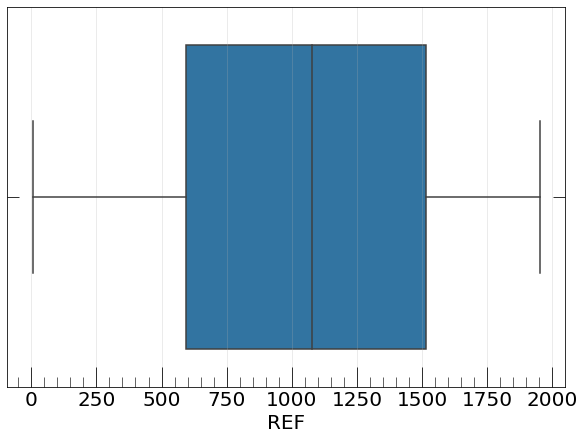

Review


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


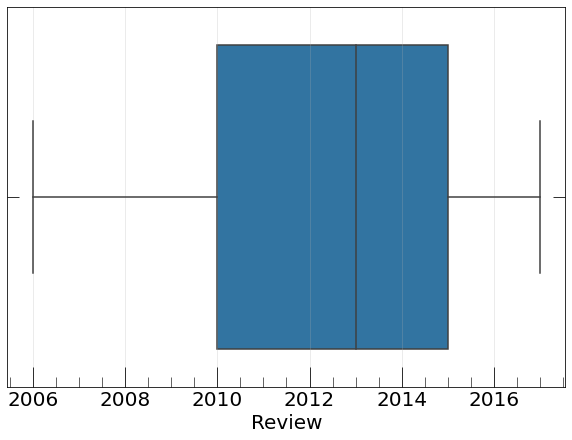

Cocoa Percent


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


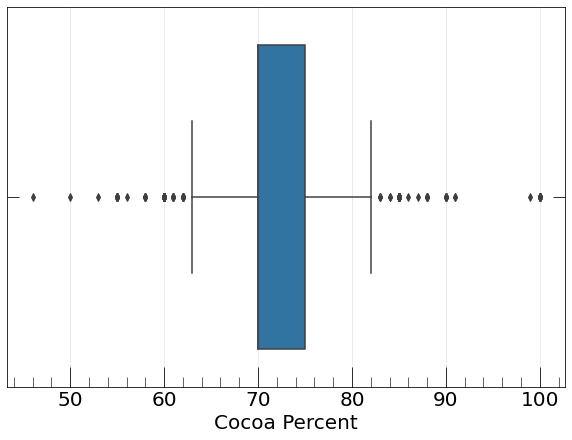

Rating


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


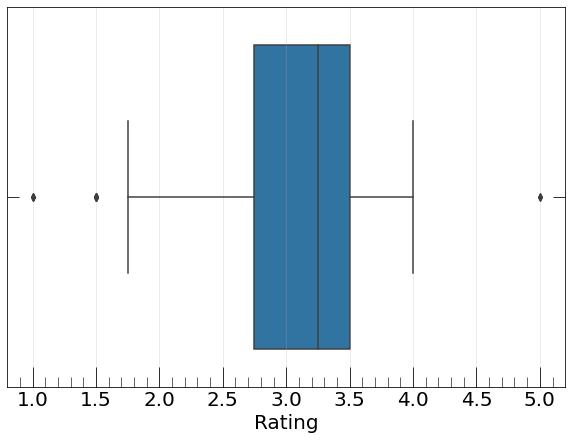

SBO Complexity


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


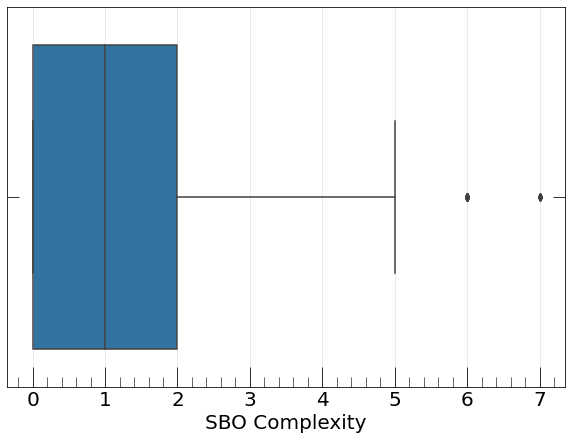

Company Upper


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


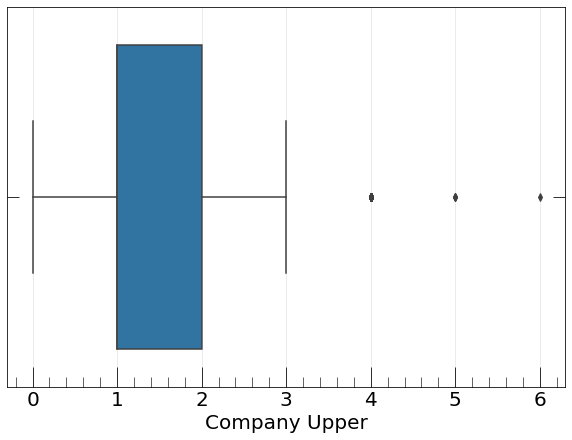

In [94]:
for col in num_cols:
    print(col)
    sns.boxplot(df_train[col])
    plt.show()

In [95]:
outliers_cocoa_percent = df_train[(df_train['Cocoa Percent'] >= 99) | (df_train['Cocoa Percent'] <= 50)]
df_train = df_train.drop(outliers_cocoa_percent.index, axis=0)

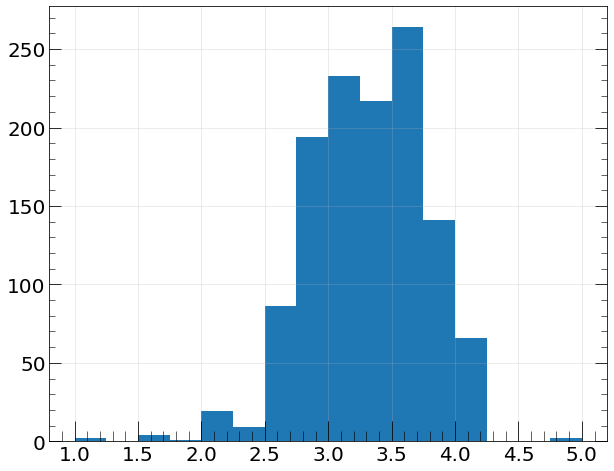

In [96]:
plt.figure(figsize=(10, 8))
plt.hist(df_train['Rating'], bins=16)
plt.show()

In [97]:
outliers_rating = df_train[(df_train['Rating'] == 5.0) | (df_train['Rating'] <= 1.5)]
df_train = df_train.drop(outliers_rating.index, axis=0)

# Baseline model (ansamble)

In [98]:
from sklearn.model_selection import train_test_split

X = df_train.drop('Rating', axis=1)
y = df_train.Rating

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [99]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# CatBoost

In [100]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([ 0,  1,  5,  6,  7,  8,  9, 10])

In [101]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

0.1671446776478872

In [103]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,19.837526
7,Broad Bean Origin,9.753900
2,REF,9.478820
4,Cocoa Percent,8.867610
5,Company Location,8.686484
6,Bean Type,7.842770
9,Broad Company Location,7.320733
10,Bean Origin World,6.947314
8,Common Bean Type,5.892273
11,SBO Complexity,5.578690


## Feature selection

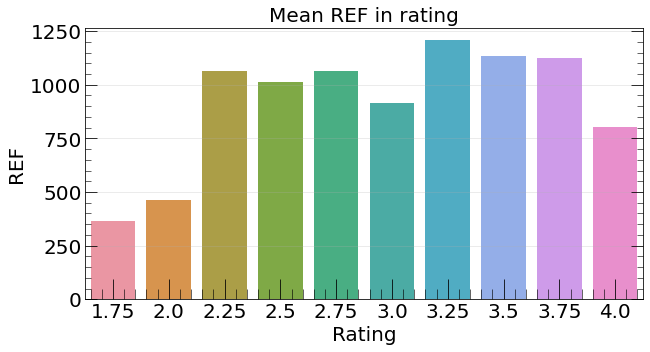

In [104]:
def distribution(data, title, x_label, y_label, figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-pastel')
    density = sns.barplot(x=data.index, y=data.values)
    title = plt.title(title, fontdict={'fontsize': 20})
    plt.xlabel(x_label)
    plt.ylabel(y_label)
plt.show()

rating_cocoa_percent_dist = df_train.groupby('Rating')['REF'].mean()

distribution(data=rating_cocoa_percent_dist,
             title='Mean REF in rating',
             x_label='Rating',
             y_label='REF')

In [105]:
train_rating = df_train.Rating
df_train.drop('Rating', axis=1, inplace=True)
df_train['Rating'] = train_rating

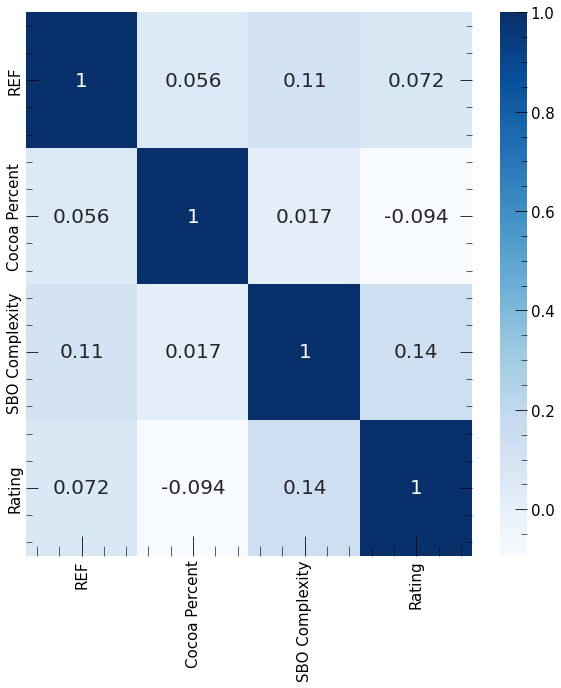

In [128]:
plt.figure(figsize = (10, 10))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr('spearman'), annot=True, cmap="Blues")

plt.show()

In [107]:
numeric_columns = df_train.columns[(df_train.dtypes == int) | (df_train.dtypes == float)]
new_columns = numeric_columns[[any(j in i for j in ['SBO', 'Company', 'Rating']) for i in numeric_columns]]
new_columns

Index(['SBO Complexity', 'Company Upper', 'Rating'], dtype='object')

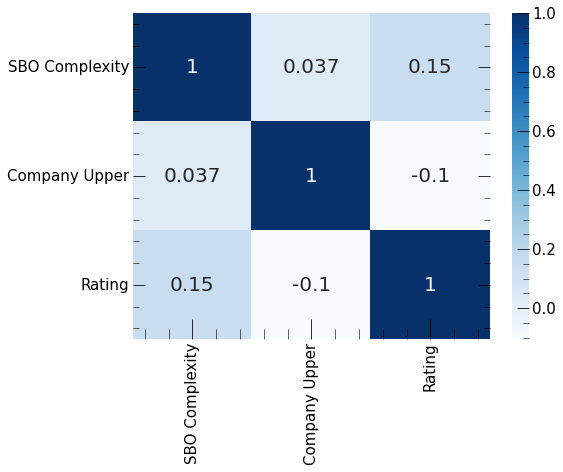

In [108]:
plt.figure(figsize = (8, 6))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train[new_columns].corr(), annot=True, cmap="Blues")

plt.show()

In [109]:
for i in range(new_columns.shape[0]):
    print(f'{i} - {new_columns[i]}')

0 - SBO Complexity
1 - Company Upper
2 - Rating


<font size="3">

Keep 'SBO Complexity' and 'Company Upper'
    
<font>

## Correlation matrix (categorical features)

In [110]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin,Common Bean Type,Broad Company Location,Bean Origin World
Company,1.000000,0.771990,0.999651,0.616787,0.602239,0.666937,0.998263,0.636328
Specific Bean Origin,0.771990,1.000000,0.809443,0.907782,0.987089,0.920540,0.844054,0.988975
Company Location,0.999651,0.809443,1.000000,0.289545,0.378702,0.385158,1.000000,0.334642
Bean Type,0.616787,0.907782,0.289545,1.000000,0.387821,1.000000,0.297409,0.393746
Broad Bean Origin,0.602239,0.987089,0.378702,0.387821,1.000000,0.600261,0.440442,1.000000
Common Bean Type,0.666937,0.920540,0.385158,1.000000,0.600261,1.000000,0.242745,0.258834
Broad Company Location,0.998263,0.844054,1.000000,0.297409,0.440442,0.242745,1.000000,0.267637
Bean Origin World,0.636328,0.988975,0.334642,0.393746,1.000000,0.258834,0.267637,1.000000


In [127]:
cols_to_drop = ['Specific Bean Origin', 'Review', 'Company Upper']
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)
df_full = df_full.drop(cols_to_drop, axis=1)

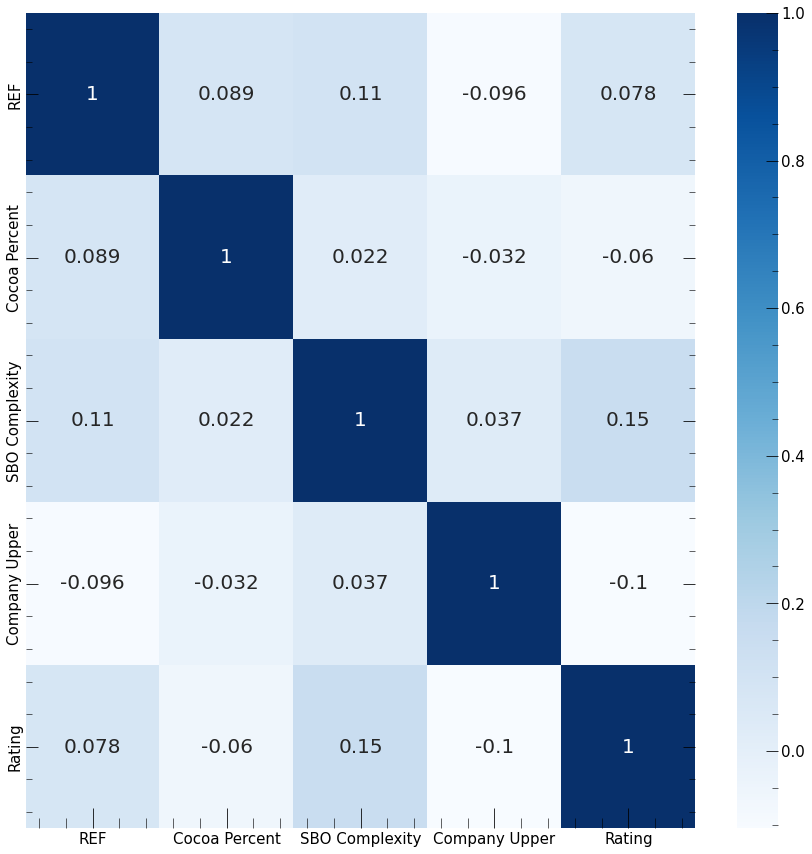

In [120]:
plt.figure(figsize = (15, 15))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

In [121]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Company Location,Bean Type,Broad Bean Origin,Common Bean Type,Broad Company Location,Bean Origin World
Company,1.000000,0.999651,0.616787,0.602239,0.666937,0.998263,0.636328
Company Location,0.999651,1.000000,0.289545,0.378702,0.385158,1.000000,0.334642
Bean Type,0.616787,0.289545,1.000000,0.387821,1.000000,0.297409,0.393746
Broad Bean Origin,0.602239,0.378702,0.387821,1.000000,0.600261,0.440442,1.000000
Common Bean Type,0.666937,0.385158,1.000000,0.600261,1.000000,0.242745,0.258834
Broad Company Location,0.998263,1.000000,0.297409,0.440442,0.242745,1.000000,0.267637
Bean Origin World,0.636328,0.334642,0.393746,1.000000,0.258834,0.267637,1.000000


# CatBoost with new features

In [129]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import optuna

In [130]:
X = df_train.drop('Rating', axis=1)
y = df_train.Rating

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [131]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([0, 3, 4, 5, 6, 7, 8])

In [132]:
model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

0.11939670999380347

In [133]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,23.393617
2,Cocoa Percent,11.660493
1,REF,10.837303
3,Company Location,10.286006
5,Broad Bean Origin,9.338316
4,Bean Type,7.589525
8,Bean Origin World,7.093633
6,Common Bean Type,6.888398
7,Broad Company Location,6.705610
9,SBO Complexity,6.207099


## CatBoost hyperparameters tuning

In [134]:
from sklearn.metrics import mean_absolute_error

In [135]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001),
        #"l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 2, 5)
        #"min_child_samples": trial.suggest_int('min_child_samples', 1, 100)
    }

    estimator = CatBoostRegressor(**param,
                                  cat_features=categorical_features_indices,
                                  custom_metric='R2',
                                  verbose=False)

    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_val)

    return mean_squared_error(y_val, pred, squared=False)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)
print(study.best_trial)

[I 2023-07-15 18:32:27,355] A new study created in memory with name: no-name-081bac05-f98a-488f-a539-789d45ce3c4f
[I 2023-07-15 18:32:28,401] Trial 0 finished with value: 0.411819924188861 and parameters: {'n_estimators': 574, 'max_depth': 2, 'learning_rate': 0.083}. Best is trial 0 with value: 0.411819924188861.
[I 2023-07-15 18:32:29,304] Trial 1 finished with value: 0.41359366254483604 and parameters: {'n_estimators': 371, 'max_depth': 4, 'learning_rate': 0.059000000000000004}. Best is trial 0 with value: 0.411819924188861.
[I 2023-07-15 18:32:30,677] Trial 2 finished with value: 0.415386185766814 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.065}. Best is trial 0 with value: 0.411819924188861.
[I 2023-07-15 18:32:31,499] Trial 4 finished with value: 0.4131994645859641 and parameters: {'n_estimators': 626, 'max_depth': 4, 'learning_rate': 0.064}. Best is trial 0 with value: 0.411819924188861.
[I 2023-07-15 18:32:32,863] Trial 6 finished with value: 0.41524

[I 2023-07-15 18:34:10,831] Trial 41 finished with value: 0.4136871936214765 and parameters: {'n_estimators': 342, 'max_depth': 9, 'learning_rate': 0.045}. Best is trial 30 with value: 0.4086443543752457.
[I 2023-07-15 18:34:10,868] Trial 38 finished with value: 0.41366134057577514 and parameters: {'n_estimators': 614, 'max_depth': 10, 'learning_rate': 0.010000000000000002}. Best is trial 30 with value: 0.4086443543752457.
[I 2023-07-15 18:34:12,192] Trial 39 finished with value: 0.41654157685460635 and parameters: {'n_estimators': 570, 'max_depth': 10, 'learning_rate': 0.011}. Best is trial 30 with value: 0.4086443543752457.
[I 2023-07-15 18:34:29,067] Trial 42 finished with value: 0.4122491935230606 and parameters: {'n_estimators': 378, 'max_depth': 9, 'learning_rate': 0.044000000000000004}. Best is trial 30 with value: 0.4086443543752457.
[I 2023-07-15 18:34:34,494] Trial 46 finished with value: 0.4110508211083925 and parameters: {'n_estimators': 775, 'max_depth': 5, 'learning_rate'

[I 2023-07-15 18:36:14,311] Trial 80 finished with value: 0.4122066270874249 and parameters: {'n_estimators': 869, 'max_depth': 5, 'learning_rate': 0.032}. Best is trial 49 with value: 0.4077034127701883.
[I 2023-07-15 18:36:18,094] Trial 82 finished with value: 0.4120154635026903 and parameters: {'n_estimators': 969, 'max_depth': 5, 'learning_rate': 0.032}. Best is trial 49 with value: 0.4077034127701883.
[I 2023-07-15 18:36:24,478] Trial 79 finished with value: 0.41394104976773255 and parameters: {'n_estimators': 873, 'max_depth': 8, 'learning_rate': 0.048}. Best is trial 49 with value: 0.4077034127701883.
[I 2023-07-15 18:36:25,624] Trial 85 finished with value: 0.41643066909945486 and parameters: {'n_estimators': 770, 'max_depth': 1, 'learning_rate': 0.026000000000000002}. Best is trial 49 with value: 0.4077034127701883.
[I 2023-07-15 18:36:36,440] Trial 83 finished with value: 0.41330385587701124 and parameters: {'n_estimators': 966, 'max_depth': 8, 'learning_rate': 0.078}. Best i

FrozenTrial(number=49, state=TrialState.COMPLETE, values=[0.4077034127701883], datetime_start=datetime.datetime(2023, 7, 15, 18, 34, 38, 817766), datetime_complete=datetime.datetime(2023, 7, 15, 18, 34, 57, 494396), params={'n_estimators': 814, 'max_depth': 8, 'learning_rate': 0.024}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1), 'learning_rate': FloatDistribution(high=0.1, log=False, low=0.001, step=0.001)}, trial_id=49, value=None)


In [136]:
print(study.best_trial.params)

{'n_estimators': 814, 'max_depth': 8, 'learning_rate': 0.024}


In [137]:
model = CatBoostRegressor(**study.best_params,
                         cat_features=categorical_features_indices,
                         logging_level='Silent')

model.fit(X_train, y_train)
pred_cb = model.predict(X_val)

r2_score(y_val, pred_cb)

0.15698255093345415

In [138]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,18.356084
5,Broad Bean Origin,12.577932
3,Company Location,10.779568
1,REF,10.326683
2,Cocoa Percent,9.599685
4,Bean Type,8.991336
8,Bean Origin World,8.826917
7,Broad Company Location,7.963285
6,Common Bean Type,6.595017
9,SBO Complexity,5.983492


## Apply tuned CatBoost to test

In [139]:
model.fit(X, y)

In [140]:
pred_test = model.predict(df_test)
pred_test[:10]

array([3.24825691, 3.03271246, 3.12044423, 3.39179821, 2.89768025,
       3.00296931, 3.05429123, 3.15597149, 3.11202688, 2.86356154])

In [141]:
df_submission = df_test.copy()
df_submission['id'] = np.arange(len(df_test))
df_submission['Rating'] = pred_test
df_submission = df_submission[['id','Rating']]
df_submission.to_csv("CatBoost_v21_new.csv", index=False)

In [142]:
print(df_train.columns)

Index(['Company', 'REF', 'Cocoa Percent', 'Company Location', 'Bean Type',
       'Broad Bean Origin', 'Common Bean Type', 'Broad Company Location',
       'Bean Origin World', 'SBO Complexity', 'Rating'],
      dtype='object')


In [143]:
print(study.best_trial.params)

{'n_estimators': 814, 'max_depth': 8, 'learning_rate': 0.024}


With above features and hyperparameters I managed to get r2 = 0.19519

## Save the model

In [ ]:
import pickle

with open('model_v13.pickle', 'wb') as f:
    pickle.dump(model, f)

# а так модель можно загрузить из файла:
with open('model_v13.pickle', 'rb') as f:
    model = pickle.load(f)